In [1]:
from model import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, Qwen2VLImageProcessor
from qwen_vl_utils import process_vision_info
import torch
from PIL import Image

In [2]:
device = 'cuda:2'

model_path = "/data/data1/syc/intern/wanshan/models/Qwen2-VL-2B-Instruct"
processor = Qwen2VLProcessor.from_pretrained(model_path, use_fast=False)

min_pixel = 256*28*28
max_pixel = 1344*28*28

messages = [
{
    "role": "user",
    "content": [
        {
            "type": "image",
            "image": "../chrome.png",
            "min_pixels": min_pixel,
            "max_pixels": max_pixel,
        },
        {"type": "text", "text": "Describe this image. write 500 words"},
    ],
}
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
).to(device)



In [3]:
# retain ratio 
retain_ratio = 0.9

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path,
    device_map=device,
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    retain_ratio=0.8
)

vit = model.visual


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
visual_tokens, select_mask = vit(inputs['pixel_values'], inputs['image_grid_thw']) 

In [5]:
visual_tokens.shape, select_mask.shape

(torch.Size([1296, 1536]), torch.Size([1296]))

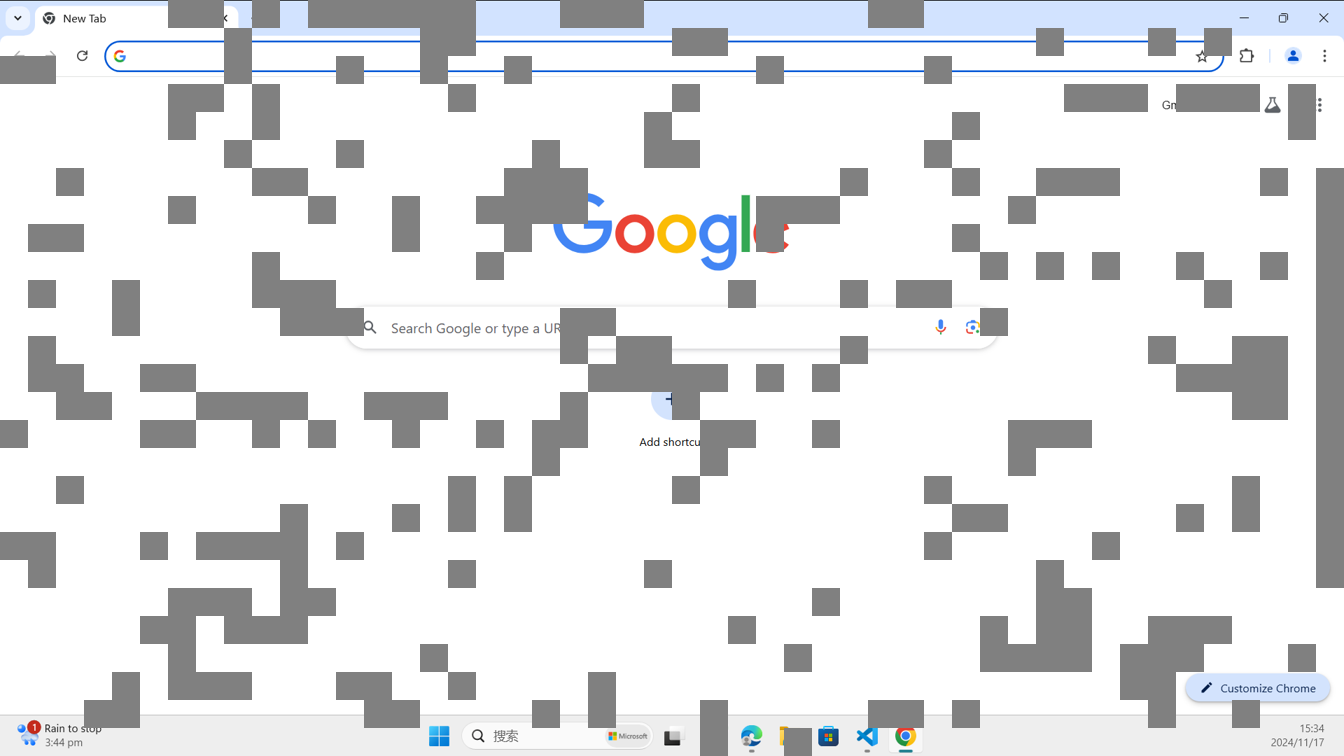

In [6]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
    select_mask=select_mask.cpu().numpy(),
    vis_dir="./visualize_imgs"
).to(device)

# show image 
img = Image.open("./visualize_imgs/demo.png")
img